# 0. Download

In [1]:
try:
    from google.colab import files
    !zip -r "/content/drive/MyDrive/AI/Disco_Diffusion/DDT-$(date +"%Y-%m-%d").zip" /content/drive/MyDrive/AI/Disco_Diffusion/images_out
except:
    print("Not in Colab")

Not in Colab


In [2]:
try:
    from google.colab import files
    !rm -rf '/content/drive/MyDrive/AI/Disco_Diffusion/images_out'
except:
    print("Not in Colab")


Not in Colab


# 1. Set Up

In [3]:
#@title 1.1 Check GPU Status
import subprocess
simple_nvidia_smi_display = False#@param {type:"boolean"}
if simple_nvidia_smi_display:
    #!nvidia-smi
    nvidiasmi_output = subprocess.run(['nvidia-smi', '-L'], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(nvidiasmi_output)
else:
    #!nvidia-smi -i 0 -e 0
    nvidiasmi_output = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(nvidiasmi_output)
    nvidiasmi_ecc_note = subprocess.run(['nvidia-smi', '-i', '0', '-e', '0'], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(nvidiasmi_ecc_note)

Wed Jul 20 16:45:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 472.12       Driver Version: 472.12       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:0A:00.0  On |                  N/A |
|  0%   51C    P3    56W / 380W |   1151MiB / 10240MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#@title 1.2 Prepare Folders
import subprocess, os, sys, ipykernel, requests

def gitclone(url, targetdir=None):
    if targetdir:
        res = subprocess.run(['git', 'clone', url, targetdir], stdout=subprocess.PIPE).stdout.decode('utf-8')
    else:
        res = subprocess.run(['git', 'clone', url], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(res)

def fetchsave(url, path):
    if is_colab:
        res = subprocess.run(['wget', url, '-O', f'{path}'], stdout=subprocess.PIPE).stdout.decode('utf-8')
        print(res)
    else:
        with open(path, 'wb') as file:
            file.write(fetch(url).getbuffer())

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith(
            'https://'):
        print(f'Fetching {str(url_or_path)}. \nThis might take a while... please wait.')
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def pipi(modulestr):
    res = subprocess.run(['pip', 'install', modulestr], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(res)

def pipie(modulestr):
    res = subprocess.run(['git', 'install', '-e', modulestr], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(res)

try:
    from google.colab import drive
    print("Google Colab detected. Using Google Drive.")
    is_colab = True
    #@markdown If you connect your Google Drive, you can save the final image of each run on your drive.
    google_drive = True #@param {type:"boolean"}
    #@markdown Click here if you'd like to save the diffusion model checkpoint file to (and/or load from) your Google Drive:
    save_models_to_google_drive = True #@param {type:"boolean"}
except:
    is_colab = False
    google_drive = False
    save_models_to_google_drive = False
    print("Google Colab not detected.")

if is_colab:
    if google_drive is True:
        drive.mount('/content/drive')
        root_path = '/content/drive/MyDrive/AI/Disco_Diffusion'
    else:
        root_path = '/content'
else:
    root_path = os.getcwd()

import os
def createPath(filepath):
    os.makedirs(filepath, exist_ok=True)

initDirPath = f'{root_path}/init_images'
createPath(initDirPath)
outDirPath = f'{root_path}/images_out'
createPath(outDirPath)
PROJECT_DIR = os.path.abspath(os.getcwd())

if is_colab:
    if google_drive and not save_models_to_google_drive or not google_drive:
        model_path = '/content/models'
        createPath(model_path)
    if google_drive and save_models_to_google_drive:
        model_path = f'{root_path}/models'
        createPath(model_path)
else:
    model_path = f'{root_path}/models'
    createPath(model_path)

# libraries = f'{root_path}/libraries'
# createPath(libraries)

Google Colab not detected.


In [5]:
#@title ### 1.3 Install, import dependencies and set up runtime devices

import pathlib, shutil, os, sys

# There are some reports that with a T4 or V100 on Colab, downgrading to a previous version of PyTorch may be necessary.
# .. but there are also reports that downgrading breaks them!  If you're facing issues, you may want to try uncommenting and running this code.
# nvidiasmi_output = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE).stdout.decode('utf-8')
# cards_requiring_downgrade = ["Tesla T4", "V100"]
# if is_colab:
#     if any(cardstr in nvidiasmi_output for cardstr in cards_requiring_downgrade):
#         print("Downgrading pytorch. This can take a couple minutes ...")
#         downgrade_pytorch_result = subprocess.run(['pip', 'install', 'torch==1.10.2', 'torchvision==0.11.3', '-q'], stdout=subprocess.PIPE).stdout.decode('utf-8')
#         print("pytorch downgraded.")

#@markdown Check this if you want to use CPU
useCPU = False #@param {type:"boolean"}

if not is_colab:
    # If running locally, there's a good chance your env will need this in order to not crash upon np.matmul() or similar operations.
    os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

PROJECT_DIR = os.path.abspath(os.getcwd())
USE_ADABINS = True

if is_colab:
    if not google_drive:
        root_path = f'/content'
        model_path = '/content/models' 
else:
    root_path = os.getcwd()
    model_path = f'{root_path}/models'

multipip_res = subprocess.run(['pip', 'install', 'lpips', 'datetime', 'timm', 'ftfy', 'einops', 'pytorch-lightning', 'omegaconf'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(multipip_res)

if is_colab:
    subprocess.run(['apt', 'install', 'imagemagick'], stdout=subprocess.PIPE).stdout.decode('utf-8')

try:
    from CLIP import clip
except:
    if not os.path.exists("CLIP"):
        gitclone("https://github.com/openai/CLIP")
    sys.path.append(f'{PROJECT_DIR}/CLIP')

try:
    import open_clip
except:
    if not os.path.exists("open_clip/src"):
        gitclone("https://github.com/mlfoundations/open_clip.git")
    sys.path.append(f'{PROJECT_DIR}/open_clip/src')
    import open_clip

try:
    from guided_diffusion.script_util import create_model_and_diffusion
except:
    if not os.path.exists("guided-diffusion"):
        gitclone("https://github.com/tanukilte/guided-diffusion")
    sys.path.append(f'{PROJECT_DIR}/guided-diffusion')

try:
    from resize_right import resize
except:
    if not os.path.exists("ResizeRight"):
        gitclone("https://github.com/assafshocher/ResizeRight.git")
    sys.path.append(f'{PROJECT_DIR}/ResizeRight')


if not os.path.exists("DiscoDiffusion"):
    gitclone("https://github.com/tanukilte/DiscoDiffusionTanuki.git")
sys.path.append(PROJECT_DIR)

import torch
from dataclasses import dataclass
from functools import partial
import cv2
import pandas as pd
import gc
import io
import math
import timm
from IPython import display
import lpips
from PIL import Image, ImageOps
import requests
from glob import glob
import json
from types import SimpleNamespace
from torch import nn
from torch.nn import functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from tqdm.notebook import tqdm
from CLIP import clip
from resize_right import resize
from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import random
from ipywidgets import Output
import hashlib
from functools import partial
if is_colab:
    os.chdir('/content')
    from google.colab import files
else:
    os.chdir(f'{PROJECT_DIR}')
from IPython.display import Image as ipyimg
from numpy import asarray
from einops import rearrange, repeat
import torch, torchvision
import time
from omegaconf import OmegaConf
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


import torch
DEVICE = torch.device('cuda:0' if (torch.cuda.is_available() and not useCPU) else 'cpu')
print('Using device:', DEVICE)
device = DEVICE # At least one of the modules expects this name..

if not useCPU:
    if torch.cuda.get_device_capability(DEVICE) == (8,0): ## A100 fix thanks to Emad
        print('Disabling CUDNN for A100 gpu', file=sys.stderr)
        torch.backends.cudnn.enabled = False
        
stop_on_next_loop = False  # Make sure GPU memory doesn't get corrupted from cancelling the run mid-way through, allow a full frame to complete
TRANSLATION_SCALE = 1.0/200.0
cutout_debug = False
padargs = {}


Using device: cuda:0


In [6]:
#@title 1.5 Define necessary functions

# https://gist.github.com/adefossez/0646dbe9ed4005480a2407c62aac8869

def interp(t):
    return 3 * t**2 - 2 * t ** 3

def val_interpolate(x1, y1, x2, y2, x):
    #Linear interpolation. Return y between y1 and y2 for the same position x is bettewen x1 and x2 
    output = (y1* (x2 - x) + y2 * (x - x1))/(x2 - x1)
    if type(y1) == int:
        output = round(output) # return the proper type
    return(output)

def smooth_jazz(schedule):

    # Take a list of numbers (i.e. an already-evaluated schedule),
    # find the places where the number changes from one to the next, and smooth those transitions
    newschedule = schedule.copy() #newschedule = [i for i in schedule]
    markers = []
    last_num = schedule[0]
    # build a list of indicies of where the number changes
    for i in range(1, len(schedule)):
        current_num = schedule[i]
        if current_num != last_num:
            markers.append(i)
        last_num = current_num
    # now smooth out the surrounding numbers for any markers we have
    lastindex = 0
    for i in range(len(markers)):
        for k in range(lastindex, markers[i]):
            newschedule[k] = val_interpolate(lastindex, schedule[lastindex], markers[i], schedule[markers[i]], k)
        lastindex = markers[i]
    return(newschedule)
import numpy as np
from scipy.special import comb
from matplotlib import pyplot as plt
from io import BytesIO

def bernstein_poly(i, n, t):
    return comb(n, i) * ( t**i ) * (1 - t)**(n-i)


def bezier_curve(points, isInt=False):
    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])
    curveEnd = 1000 - points[-1][0]
    t = np.linspace(0.0, 1.0, 1000 - curveEnd)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    #xvals = np.dot(xPoints, polynomial_array)
    xvals = [i for i in range(1000)]
    yvals = np.dot(yPoints, polynomial_array)
    if isInt:
        yvals = [round(i) for i in yvals]
    if curveEnd > 0:
        yvals = list(yvals) + [yvals[-1] for i in range(1000 - curveEnd, 1000)]
    return xvals, yvals

def plot_bezier(points, isInt=False, reg=None):
    xpoints = [p[0] for p in points]
    ypoints = [p[1] for p in points]
    name = [name for name in globals() if globals()[name] is points]
    if name is not None:
        if len(name) > 0:
            plt.title(name[0])
    xvals, yvals = bezier_curve(points, isInt=isInt)
    plt.plot(xvals, yvals)
    plt.plot(xpoints, ypoints, "ro")
    for nr in range(len(points)):
        plt.text(points[nr][0], points[nr][1], nr)
    if reg is not None:
        x1 = [i for i in range(1000)]
        plt.plot(x1, reg, label = "line 1")   
    
def perlin(width, height, scale=10, device=None):
    gx, gy = torch.randn(2, width + 1, height + 1, 1, 1, device=device)
    xs = torch.linspace(0, 1, scale + 1)[:-1, None].to(device)
    ys = torch.linspace(0, 1, scale + 1)[None, :-1].to(device)
    wx = 1 - interp(xs)
    wy = 1 - interp(ys)
    dots = 0
    dots += wx * wy * (gx[:-1, :-1] * xs + gy[:-1, :-1] * ys)
    dots += (1 - wx) * wy * (-gx[1:, :-1] * (1 - xs) + gy[1:, :-1] * ys)
    dots += wx * (1 - wy) * (gx[:-1, 1:] * xs - gy[:-1, 1:] * (1 - ys))
    dots += (1 - wx) * (1 - wy) * (-gx[1:, 1:] * (1 - xs) - gy[1:, 1:] * (1 - ys))
    return dots.permute(0, 2, 1, 3).contiguous().view(width * scale, height * scale)

def perlin_ms(octaves, width, height, grayscale, device=device):
    out_array = [0.5] if grayscale else [0.5, 0.5, 0.5]
    # out_array = [0.0] if grayscale else [0.0, 0.0, 0.0]
    for i in range(1 if grayscale else 3):
        scale = 2 ** len(octaves)
        oct_width = width
        oct_height = height
        for oct in octaves:
            p = perlin(oct_width, oct_height, scale, device)
            out_array[i] += p * oct
            scale //= 2
            oct_width *= 2
            oct_height *= 2
    return torch.cat(out_array)

def create_perlin_noise(octaves=[1, 1, 1, 1], width=2, height=2, grayscale=True):
    out = perlin_ms(octaves, width, height, grayscale)
    if grayscale:
        out = TF.resize(size=(side_y, side_x), img=out.unsqueeze(0))
        out = TF.to_pil_image(out.clamp(0, 1)).convert('RGB')
    else:
        out = out.reshape(-1, 3, out.shape[0]//3, out.shape[1])
        out = TF.resize(size=(side_y, side_x), img=out)
        out = TF.to_pil_image(out.clamp(0, 1).squeeze())

    out = ImageOps.autocontrast(out)
    return out

def regen_perlin():
    if perlin_mode == 'color':
        init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, False)
        init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, False)
    elif perlin_mode == 'gray':
        init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, True)
        init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, True)
    else:
        init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, False)
        init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, True)

    init = TF.to_tensor(init).add(TF.to_tensor(init2)).div(2).to(device).unsqueeze(0).mul(2).sub(1)
    del init2
    return init.expand(batch_size, -1, -1, -1)

def read_image_workaround(path):
    """OpenCV reads images as BGR, Pillow saves them as RGB. Work around
    this incompatibility to avoid colour inversions."""
    im_tmp = cv2.imread(path)
    return cv2.cvtColor(im_tmp, cv2.COLOR_BGR2RGB)

def parse_prompt(prompt):
    if prompt.startswith('http://') or prompt.startswith('https://'):
        vals = prompt.rsplit(':', 2)
        vals = [vals[0] + ':' + vals[1], *vals[2:]]
    else:
        vals = prompt.rsplit(':', 1)
    vals = vals + ['', '1'][len(vals):]
    return vals[0], float(vals[1])

def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))

def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()

def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]

def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.reshape([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.reshape([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)

class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, skip_augs=False):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.skip_augs = skip_augs
        self.augs = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.RandomAffine(degrees=15, translate=(0.1, 0.1)),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.RandomPerspective(distortion_scale=0.4, p=0.7),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.RandomGrayscale(p=0.15),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            # T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        ])

    def forward(self, input):
        input = T.Pad(input.shape[2]//4, fill=0)(input)
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)

        cutouts = []
        for ch in range(self.cutn):
            if ch > self.cutn - self.cutn//4:
                cutout = input.clone()
            else:
                size = int(max_size * torch.zeros(1,).normal_(mean=.8, std=.3).clip(float(self.cut_size/max_size), 1.))
                offsetx = torch.randint(0, abs(sideX - size + 1), ())
                offsety = torch.randint(0, abs(sideY - size + 1), ())
                cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]

            if not self.skip_augs:
                cutout = self.augs(cutout)
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
            del cutout

        cutouts = torch.cat(cutouts, dim=0)
        return cutouts

class MakeCutoutsDango(nn.Module):
    def __init__(self, cut_size,
                 Overview=4, 
                 InnerCrop = 0, IC_Size_Pow=0.5, IC_Grey_P = 0.2
                 ):
        super().__init__()
        self.cut_size = cut_size
        self.Overview = Overview
        self.InnerCrop = InnerCrop
        self.IC_Size_Pow = IC_Size_Pow
        self.IC_Grey_P = IC_Grey_P
        if args.animation_mode == 'None':
            self.augs = T.Compose([
                T.RandomHorizontalFlip(p=0.5),
                T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                T.RandomAffine(degrees=10, translate=(0.05, 0.05),  interpolation = T.InterpolationMode.BILINEAR),
                T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                T.RandomGrayscale(p=0.1),
                T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            ])
        elif args.animation_mode == 'Video Input':
            self.augs = T.Compose([
                T.RandomHorizontalFlip(p=0.5),
                T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                T.RandomAffine(degrees=15, translate=(0.1, 0.1)),
                T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                T.RandomPerspective(distortion_scale=0.4, p=0.7),
                T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                T.RandomGrayscale(p=0.15),
                T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                # T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            ])
        elif  args.animation_mode == '2D' or args.animation_mode == '3D':
            self.augs = T.Compose([
                T.RandomHorizontalFlip(p=0.4),
                T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                T.RandomAffine(degrees=10, translate=(0.05, 0.05),  interpolation = T.InterpolationMode.BILINEAR),
                T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                T.RandomGrayscale(p=0.1),
                T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.3),
            ])
          

    def forward(self, input):
        cutouts = []
        gray = T.Grayscale(3)
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        l_size = max(sideX, sideY)
        output_shape = [1,3,self.cut_size,self.cut_size] 
        output_shape_2 = [1,3,self.cut_size+2,self.cut_size+2]
        pad_input = F.pad(input,((sideY-max_size)//2,(sideY-max_size)//2,(sideX-max_size)//2,(sideX-max_size)//2), **padargs)
        #MOD more useful cuts
        if self.Overview > 0:
            for i in range(self.Overview):
                cutout = resize(pad_input, out_shape=output_shape)
                if random.random() < self.IC_Grey_P:
                    if random.random() < 0.5:
                        cutouts.append(gray(TF.hflip(cutout)))
                    else:
                        cutouts.append(gray(cutout))
                else:
                    if random.random() < 0.5:
                        cutouts.append(TF.hflip(cutout))
                    else:
                        cutouts.append(cutout)

            if cutout_debug:
                if is_colab:
                    TF.to_pil_image(cutouts[0].clamp(0, 1).squeeze(0)).save("/content/cutout_overview0.jpg",quality=99)
                else:
                    TF.to_pil_image(cutouts[0].clamp(0, 1).squeeze(0)).save("cutout_overview0.jpg",quality=99)

                              
        if self.InnerCrop >0:
            for i in range(self.InnerCrop):
                size = int(torch.rand([])**self.IC_Size_Pow * (max_size - min_size) + min_size)
                offsetx = torch.randint(0, sideX - size + 1, ())
                offsety = torch.randint(0, sideY - size + 1, ())
                cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
                if random.random() < self.IC_Grey_P:
                    cutout = gray(cutout)
                cutout = resize(cutout, out_shape=output_shape)
                cutouts.append(cutout)
            if cutout_debug:
                if is_colab:
                    TF.to_pil_image(cutouts[-1].clamp(0, 1).squeeze(0)).save("/content/cutout_InnerCrop.jpg",quality=99)
                else:
                    TF.to_pil_image(cutouts[-1].clamp(0, 1).squeeze(0)).save("cutout_InnerCrop.jpg",quality=99)
        cutouts = torch.cat(cutouts)
        if skip_augs is not True:
            for i in range(cutouts.shape[0]):
                cutouts[i]=self.augs(cutouts[i])
        return cutouts

def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)     

def tv_loss(input):
    """L2 total variation loss, as in Mahendran et al."""
    input = F.pad(input, (0, 1, 0, 1), 'replicate')
    x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
    y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
    return (x_diff**2 + y_diff**2).mean([1, 2, 3])


def range_loss(input):
    return (input - input.clamp(-1, 1)).pow(2).mean([1, 2, 3])

def symmetry_transformation_fn(x):
    if args.use_horizontal_symmetry:
        [n, c, h, w] = x.size()
        x = torch.concat((x[:, :, :, :w//2], torch.flip(x[:, :, :, :w//2], [-1])), -1)
        print("horizontal symmetry applied")
    if args.use_vertical_symmetry:
        [n, c, h, w] = x.size()
        x = torch.concat((x[:, :, :h//2, :], torch.flip(x[:, :, :h//2, :], [-2])), -2)
        print("vertical symmetry applied")
    return x

def do_run():
    seed = args.seed# + batch_num
    display.clear_output(wait=True)

    if args.init_image in ['','none', 'None', 'NONE']:
        init_image = None
    else:
        init_image = args.init_image
        init_scale = args.init_scale
        skip_steps = args.skip_steps




    loss_values = []

    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

    target_embeds, weights = [], []

    if args.prompts_series is not None:
        prompts = args.prompts_series
    else:
        prompts = []

    
    if args.image_prompts_series is not None:
        print(args.image_prompts_series)
        image_prompts = args.image_prompts_series
    else:
        image_prompts = []

    model_stats = []
    for clip_model in clip_models:
        cutn = 16
        model_stat = {"clip_model":None,"target_embeds":[],"make_cutouts":None,"weights":[]}
        model_stat["clip_model"] = clip_model

        for prompt in prompts:
            txt, weight = parse_prompt(prompt)
            txt = clip_model.encode_text(clip.tokenize(prompt).to(device)).float()

            if args.fuzzy_prompt:
                for i in range(25):
                    model_stat["target_embeds"].append((txt + torch.randn(txt.shape).cuda() * args.rand_mag).clamp(0,1))
                    model_stat["weights"].append(weight)
            else:
                model_stat["target_embeds"].append(txt)
                model_stat["weights"].append(weight)

        if image_prompts:
            model_stat["make_cutouts"] = MakeCutouts(clip_model.visual.input_resolution, cutn, skip_augs=skip_augs) 
            for prompt in image_prompt:
                path, weight = parse_prompt(prompt)
                img = Image.open(fetch(path)).convert('RGB')
                img = TF.resize(img, min(side_x, side_y, *img.size), T.InterpolationMode.LANCZOS)
                batch = model_stat["make_cutouts"](TF.to_tensor(img).to(device).unsqueeze(0).mul(2).sub(1))
                embed = clip_model.encode_image(normalize(batch)).float()
                if fuzzy_prompt:
                    for i in range(25):
                        model_stat["target_embeds"].append((embed + torch.randn(embed.shape).cuda() * rand_mag).clamp(0,1))
                        weights.extend([weight / cutn] * cutn)
                else:
                    model_stat["target_embeds"].append(embed)
                    model_stat["weights"].extend([weight / cutn] * cutn)

        model_stat["target_embeds"] = torch.cat(model_stat["target_embeds"])
        model_stat["weights"] = torch.tensor(model_stat["weights"], device=device)
        if model_stat["weights"].sum().abs() < 1e-3:
            raise RuntimeError('The weights must not sum to 0.')
        model_stat["weights"] /= model_stat["weights"].sum().abs()
        model_stats.append(model_stat)

        init = None
        if init_image is not None:
            init = Image.open(fetch(init_image)).convert('RGB')
            init = init.resize((args.side_x, args.side_y), Image.LANCZOS)
            init = TF.to_tensor(init).to(device).unsqueeze(0).mul(2).sub(1)

    if args.perlin_init:
        if args.perlin_mode == 'color':
            init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, False)
            init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, False)
        elif args.perlin_mode == 'gray':
            init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, True)
            init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, True)
        else:
            init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, False)
            init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, True)
        #init = TF.to_tensor(init).add(TF.to_tensor(init2)).div(2).to(device)
        init = TF.to_tensor(init).add(TF.to_tensor(init2)).div(2).to(device).unsqueeze(0).mul(2).sub(1)
        del init2

    cur_t = None

    def cond_fn(x, t, y=None):
        with torch.enable_grad():
            x_is_NaN = False
            x = x.detach().requires_grad_()
            n = x.shape[0]
            if use_secondary_model is True:
                alpha = torch.tensor(diffusion.sqrt_alphas_cumprod[cur_t], device=device, dtype=torch.float32)
                sigma = torch.tensor(diffusion.sqrt_one_minus_alphas_cumprod[cur_t], device=device, dtype=torch.float32)
                cosine_t = alpha_sigma_to_t(alpha, sigma)
                out = secondary_model(x, cosine_t[None].repeat([n])).pred
                fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
                x_in = out * fac + x * (1 - fac)
                x_in_grad = torch.zeros_like(x_in)
            else:
                my_t = torch.ones([n], device=device, dtype=torch.long) * cur_t
                out = diffusion.p_mean_variance(model, x, my_t, clip_denoised=False, model_kwargs={'y': y})
                fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
                x_in = out['pred_xstart'] * fac + x * (1 - fac)
                x_in_grad = torch.zeros_like(x_in)
                
            #MOD this whole chunk and spliting off cuts outer/inner:
            normalizeGuideToRes = width_height[0] * width_height[1] / 425984.0 #Normalize to 832,512 res
                
            for model_stat in model_stats:
                t_int = int(t.item())+1 #errors on last step without +1, need to find source
                #when using SLIP Base model the dimensions need to be hard coded to avoid AttributeError: 'VisionTransformer' object has no attribute 'input_resolution'
                try:
                    input_resolution=model_stat["clip_model"].visual.input_resolution
                except:
                    input_resolution=224
                for i in range(args.cutn_batches[1000-t_int]):
                    cuts = MakeCutoutsDango(input_resolution,
                            Overview= args.cut_overview[1000-t_int], 
                            InnerCrop =args.cut_innercut[1000-t_int],
                            IC_Size_Pow=args.cut_ic_pow[1000-t_int],
                            IC_Grey_P = args.cut_icgray_p[1000-t_int]
                            )
                    clip_in = normalize(cuts(x_in.add(1).div(2)))
                    image_embeds = model_stat["clip_model"].encode_image(clip_in).float()
                    dists = spherical_dist_loss(image_embeds.unsqueeze(1), model_stat["target_embeds"].unsqueeze(0))
                    dists = dists.view([args.cut_overview[1000-t_int] + args.cut_innercut[1000-t_int], n, -1])
                    losses = dists.mul(model_stat["weights"]).sum(2).mean(0)
                    #loss_values.append(losses.sum().item()) # log loss, probably shouldn't do per cutn_batch
                    x_in_grad += torch.autograd.grad(losses.sum() * args.clip_guidance_scale[1000-t_int], x_in)[0] #/ args.cutn_batches[1000-t_int]
            tv_losses = tv_loss(x_in)
            if use_secondary_model is True:
                range_losses = range_loss(out)
            else:
                range_losses = range_loss(out['pred_xstart'])
            sat_losses = torch.abs(x_in - x_in.clamp(min=-1,max=1)).mean()
            loss = tv_losses.sum() * tv_scale + range_losses.sum() * range_scale + sat_losses.sum() * sat_scale
            #if init is not None and init_scale:
                #init_losses = lpips_model(x_in, init)
                #loss = loss + init_losses.sum() * init_scale
            x_in_grad += torch.autograd.grad(loss, x_in)[0]
            if torch.isnan(x_in_grad).any()==False:
                grad = -torch.autograd.grad(x_in, x, x_in_grad)[0]
            else:
                # print("NaN'd")
                x_is_NaN = True
                grad = torch.zeros_like(x)
        if args.clamp_grad and x_is_NaN == False:
            magnitude = grad.square().mean().sqrt()
            grad = grad * magnitude.clamp(max=args.clamp_max[1000 - t_int]) / magnitude  #min=-0.02, min=-clamp_max, 
        #MOD:    
        #Static thresholding: We refer to elementwise clipping the x-prediction to [−1, 1] as static thresholding. This method was in fact used but not emphasized in previous work [28 ], and to our knowledge its importance has not been investigated in the context of guided sampling. We discover that static thresholding is essential to sampling with large guidance weights and prevents generation of blank images. Nonetheless, static thresholding still results in over-saturated and less detailed images as the guidance weight further increases.
        #made dynamic clamp instead of regular clamp
        return grad.div(max(grad.max(), 0.0 - grad.min(), 1.0))

    if args.diffusion_sampling_mode == 'ddim':
        sample_fn = diffusion.ddim_sample_loop_progressive
    else:
        sample_fn = diffusion.plms_sample_loop_progressive


    image_display = Output()
    for i in range(args.n_batches):
        display.clear_output(wait=True)
        batchBar = tqdm(range(args.n_batches), desc ="Batches")
        batchBar.n = i
        batchBar.refresh()
        print('')
        display.display(image_display)
        gc.collect()
        torch.cuda.empty_cache()
        cur_t = diffusion.num_timesteps - skip_steps - 1
        total_steps = cur_t

        if perlin_init:
            init = regen_perlin()

        if args.diffusion_sampling_mode == 'ddim':
            samples = sample_fn(
                model,
                (batch_size, 3, args.side_y, args.side_x),
                clip_denoised=clip_denoised,
                model_kwargs={},
                cond_fn=cond_fn,
                progress=True,
                skip_timesteps=skip_steps,
                init_image=init,
                randomize_class=randomize_class,
                eta=args.eta,
                dynamicThreshold=args.dynamicThreshold,
                transformation_fn=symmetry_transformation_fn,
                transformation_percent=args.transformation_percent
            )
        else:
            samples = sample_fn(
                model,
                (batch_size, 3, args.side_y, args.side_x),
                clip_denoised=clip_denoised,
                model_kwargs={},
                cond_fn=cond_fn,
                progress=True,
                skip_timesteps=skip_steps,
                init_image=init,
                randomize_class=randomize_class,
                order=2,
        )

        # with run_display:
        # display.clear_output(wait=True)
        for j, sample in enumerate(samples):    
            cur_t -= 1
            intermediateStep = False
            if args.steps_per_checkpoint is not None:
                if j % steps_per_checkpoint == 0 and j > 0:
                    intermediateStep = True
            elif j in args.intermediate_saves:
                intermediateStep = True
            with image_display:
                if j % args.display_rate == 0 or cur_t == -1 or intermediateStep == True:
                    for k, image in enumerate(sample['pred_xstart']):
                        # tqdm.write(f'Batch {i}, step {j}, output {k}:')
                        current_time = datetime.now().strftime('%y%m%d-%H%M%S_%f')
                        percent = math.ceil(j/total_steps*100)
                        if args.n_batches > 0:
                            #if intermediates are saved to the subfolder, don't append a step or percentage to the name
                            if cur_t == -1 and args.intermediates_in_subfolder is True:
                                save_num = f'{frame_num:04}' if args.animation_mode != "None" else i
                                filename = f'{args.batch_name}({args.batchNum})_{save_num}.png'
                            else:
                                #If we're working with percentages, append it
                                if args.steps_per_checkpoint is not None:
                                    filename = f'{args.batch_name}({args.batchNum})_{i:04}-{percent:02}%.png'
                                # Or else, iIf we're working with specific steps, append those
                                else:
                                    filename = f'{args.batch_name}({args.batchNum})_{i:04}-{j:03}.png'
                        image = TF.to_pil_image(image.add(1).div(2).clamp(0, 1))
                        if j % args.display_rate == 0 or cur_t == -1:
                            image.save('progress.png')
                            display.clear_output(wait=True)
                            display.display(display.Image('progress.png'))
                        if args.steps_per_checkpoint is not None:
                            if j % args.steps_per_checkpoint == 0 and j > 0:
                                if args.intermediates_in_subfolder is True:
                                    image.save(f'{partialFolder}/{filename}')
                                else:
                                    image.save(f'{batchFolder}/{filename}')
                        else:
                            if j in args.intermediate_saves:
                                if args.intermediates_in_subfolder is True:
                                    image.save(f'{partialFolder}/{filename}')
                                else:
                                    image.save(f'{batchFolder}/{filename}')
                        if cur_t == -1:
                            save_settings()
                            image.save(f'{batchFolder}/{filename}')
                    
      #plt.plot(np.array(loss_values), 'r')

def save_settings():
    setting_list = {
        'text_prompts': text_prompts,
        'image_prompts': image_prompts,
        'clip_guidance_scale': clip_guidance_scale,
        'tv_scale': tv_scale,
        'range_scale': range_scale,
        'sat_scale': sat_scale,
        'cutn_batches': cutn_batches,
        'init_image': init_image,
        'init_scale': init_scale,
        'skip_steps': skip_steps,
        'perlin_init': perlin_init,
        'perlin_mode': perlin_mode,
        'skip_augs': skip_augs,
        'randomize_class': randomize_class,
        'clip_denoised': clip_denoised,
        'clamp_grad': clamp_grad,
        'clamp_max': clamp_max,
        'seed': seed,
        'fuzzy_prompt': fuzzy_prompt,
        'rand_mag': rand_mag,
        'eta': eta,
        "dynamicThreshold": dynamicThreshold,
        'width': width_height[0],
        'height': width_height[1],
        'diffusion_model': diffusion_model,
        'use_secondary_model': use_secondary_model,
        'steps': steps,
        'diffusion_steps': diffusion_steps,
        'diffusion_sampling_mode': diffusion_sampling_mode,
        'ViTB32': ViTB32,
        'ViTB16': ViTB16,
        'ViTL14': ViTL14,
        'ViTL14_336px': ViTL14_336px,
        'RN101': RN101,
        'RN50': RN50,
        'RN50x4': RN50x4,
        'RN50x16': RN50x16,
        'RN50x64': RN50x64,
        'ViTB32_laion2b_e16': ViTB32_laion2b_e16,
        'ViTB32_laion400m_e31': ViTB32_laion400m_e31,
        'ViTB32_laion400m_32': ViTB32_laion400m_32,
        'ViTB32quickgelu_laion400m_e31': ViTB32quickgelu_laion400m_e31,
        'ViTB32quickgelu_laion400m_e32': ViTB32quickgelu_laion400m_e32,
        'ViTB16_laion400m_e31': ViTB16_laion400m_e31,
        'ViTB16_laion400m_e32': ViTB16_laion400m_e32,
        'RN50_yffcc15m': RN50_yffcc15m,
        'RN50_cc12m': RN50_cc12m,
        'RN50_quickgelu_yfcc15m': RN50_quickgelu_yfcc15m,
        'RN50_quickgelu_cc12m': RN50_quickgelu_cc12m,
        'RN101_yfcc15m': RN101_yfcc15m,
        'RN101_quickgelu_yfcc15m': RN101_quickgelu_yfcc15m,
        'cut_overview': str(cut_overview),
        'cut_innercut': str(cut_innercut),
        'cut_ic_pow': str(cut_ic_pow),
        'cut_icgray_p': str(cut_icgray_p),
        'sampling_mode': sampling_mode,
        'use_horizontal_symmetry':use_horizontal_symmetry,
        'use_vertical_symmetry':use_vertical_symmetry,
        'transformation_percent':transformation_percent,
    }
    # print('Settings:', setting_list)
    with open(f"{batchFolder}/{batch_name}({batchNum})_settings.txt", "w+") as f:   #save settings
        json.dump(setting_list, f, ensure_ascii=False, indent=4)

In [7]:
#@title 1.6 Define the secondary diffusion model

def append_dims(x, n):
    return x[(Ellipsis, *(None,) * (n - x.ndim))]


def expand_to_planes(x, shape):
    return append_dims(x, len(shape)).repeat([1, 1, *shape[2:]])


def alpha_sigma_to_t(alpha, sigma):
    return torch.atan2(sigma, alpha) * 2 / math.pi


def t_to_alpha_sigma(t):
    return torch.cos(t * math.pi / 2), torch.sin(t * math.pi / 2)


@dataclass
class DiffusionOutput:
    v: torch.Tensor
    pred: torch.Tensor
    eps: torch.Tensor


class ConvBlock(nn.Sequential):
    def __init__(self, c_in, c_out):
        super().__init__(
            nn.Conv2d(c_in, c_out, 3, padding=1),
            nn.ReLU(inplace=True),
        )


class SkipBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return torch.cat([self.main(input), self.skip(input)], dim=1)


class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, std=1.):
        super().__init__()
        assert out_features % 2 == 0
        self.weight = nn.Parameter(torch.randn([out_features // 2, in_features]) * std)

    def forward(self, input):
        f = 2 * math.pi * input @ self.weight.T
        return torch.cat([f.cos(), f.sin()], dim=-1)


class SecondaryDiffusionImageNet(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64  # The base channel count

        self.timestep_embed = FourierFeatures(1, 16)

        self.net = nn.Sequential(
            ConvBlock(3 + 16, c),
            ConvBlock(c, c),
            SkipBlock([
                nn.AvgPool2d(2),
                ConvBlock(c, c * 2),
                ConvBlock(c * 2, c * 2),
                SkipBlock([
                    nn.AvgPool2d(2),
                    ConvBlock(c * 2, c * 4),
                    ConvBlock(c * 4, c * 4),
                    SkipBlock([
                        nn.AvgPool2d(2),
                        ConvBlock(c * 4, c * 8),
                        ConvBlock(c * 8, c * 4),
                        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                    ]),
                    ConvBlock(c * 8, c * 4),
                    ConvBlock(c * 4, c * 2),
                    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                ]),
                ConvBlock(c * 4, c * 2),
                ConvBlock(c * 2, c),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            ]),
            ConvBlock(c * 2, c),
            nn.Conv2d(c, 3, 3, padding=1),
        )

    def forward(self, input, t):
        timestep_embed = expand_to_planes(self.timestep_embed(t[:, None]), input.shape)
        v = self.net(torch.cat([input, timestep_embed], dim=1))
        alphas, sigmas = map(partial(append_dims, n=v.ndim), t_to_alpha_sigma(t))
        pred = input * alphas - v * sigmas
        eps = input * sigmas + v * alphas
        return DiffusionOutput(v, pred, eps)


class SecondaryDiffusionImageNet2(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64  # The base channel count
        cs = [c, c * 2, c * 2, c * 4, c * 4, c * 8]

        self.timestep_embed = FourierFeatures(1, 16)
        self.down = nn.AvgPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.net = nn.Sequential(
            ConvBlock(3 + 16, cs[0]),
            ConvBlock(cs[0], cs[0]),
            SkipBlock([
                self.down,
                ConvBlock(cs[0], cs[1]),
                ConvBlock(cs[1], cs[1]),
                SkipBlock([
                    self.down,
                    ConvBlock(cs[1], cs[2]),
                    ConvBlock(cs[2], cs[2]),
                    SkipBlock([
                        self.down,
                        ConvBlock(cs[2], cs[3]),
                        ConvBlock(cs[3], cs[3]),
                        SkipBlock([
                            self.down,
                            ConvBlock(cs[3], cs[4]),
                            ConvBlock(cs[4], cs[4]),
                            SkipBlock([
                                self.down,
                                ConvBlock(cs[4], cs[5]),
                                ConvBlock(cs[5], cs[5]),
                                ConvBlock(cs[5], cs[5]),
                                ConvBlock(cs[5], cs[4]),
                                self.up,
                            ]),
                            ConvBlock(cs[4] * 2, cs[4]),
                            ConvBlock(cs[4], cs[3]),
                            self.up,
                        ]),
                        ConvBlock(cs[3] * 2, cs[3]),
                        ConvBlock(cs[3], cs[2]),
                        self.up,
                    ]),
                    ConvBlock(cs[2] * 2, cs[2]),
                    ConvBlock(cs[2], cs[1]),
                    self.up,
                ]),
                ConvBlock(cs[1] * 2, cs[1]),
                ConvBlock(cs[1], cs[0]),
                self.up,
            ]),
            ConvBlock(cs[0] * 2, cs[0]),
            nn.Conv2d(cs[0], 3, 3, padding=1),
        )

    def forward(self, input, t):
        timestep_embed = expand_to_planes(self.timestep_embed(t[:, None]), input.shape)
        v = self.net(torch.cat([input, timestep_embed], dim=1))
        alphas, sigmas = map(partial(append_dims, n=v.ndim), t_to_alpha_sigma(t))
        pred = input * alphas - v * sigmas
        eps = input * sigmas + v * alphas
        return DiffusionOutput(v, pred, eps)

# 2. Diffusion and CLIP model settings

In [8]:
#@markdown ####**Models Settings (note: For pixel art, the best is pixelartdiffusion_expanded):**
diffusion_model = "512x512_diffusion_uncond_finetune_008100" #@param ["256x256_diffusion_uncond", "512x512_diffusion_uncond_finetune_008100", "portrait_generator_v001", "pixelartdiffusion_expanded", "pixel_art_diffusion_hard_256", "pixel_art_diffusion_soft_256", "pixelartdiffusion4k", "watercolordiffusion_2", "watercolordiffusion", "PulpSciFiDiffusion", "custom"]

use_secondary_model = True #@param {type: 'boolean'}
diffusion_sampling_mode = 'ddim' #@param ['plms','ddim']
#@markdown #####**Custom model:**
custom_path = '/content/drive/MyDrive/deep_learning/ddpm/ema_0.9999_058000.pt'#@param {type: 'string'}

#@markdown #####**CLIP settings:**
use_checkpoint = True #@param {type: 'boolean'}
ViTB32 = True #@param{type:"boolean"}
ViTB16 = True #@param{type:"boolean"}
ViTL14 = True #@param{type:"boolean"}
ViTL14_336px = False #@param{type:"boolean"}
RN101 = False #@param{type:"boolean"}
RN50 = False #@param{type:"boolean"}
RN50x4 = False #@param{type:"boolean"}
RN50x16 = True #@param{type:"boolean"}
RN50x64 = False #@param{type:"boolean"}

#@markdown #####**OpenCLIP settings:**
ViTB32_laion2b_e16 = False #@param{type:"boolean"}
ViTB32_laion400m_e31 = False #@param{type:"boolean"}
ViTB32_laion400m_32 = False #@param{type:"boolean"}
ViTB32quickgelu_laion400m_e31 = False #@param{type:"boolean"}
ViTB32quickgelu_laion400m_e32 = False #@param{type:"boolean"}
ViTB16_laion400m_e31 = False #@param{type:"boolean"}
ViTB16_laion400m_e32 = False #@param{type:"boolean"}
RN50_yffcc15m = False #@param{type:"boolean"}
RN50_cc12m = False #@param{type:"boolean"}
RN50_quickgelu_yfcc15m = False #@param{type:"boolean"}
RN50_quickgelu_cc12m = False #@param{type:"boolean"}
RN101_yfcc15m = False #@param{type:"boolean"}
RN101_quickgelu_yfcc15m = False #@param{type:"boolean"}

#@markdown If you're having issues with model downloads, check this to compare SHA's:
check_model_SHA = False #@param{type:"boolean"}

diff_model_map = {
    '256x256_diffusion_uncond': { 'downloaded': False, 'sha': 'a37c32fffd316cd494cf3f35b339936debdc1576dad13fe57c42399a5dbc78b1', 'uri_list': ['https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt', 'https://www.dropbox.com/s/9tqnqo930mpnpcn/256x256_diffusion_uncond.pt'] },
    '512x512_diffusion_uncond_finetune_008100': { 'downloaded': False, 'sha': '9c111ab89e214862b76e1fa6a1b3f1d329b1a88281885943d2cdbe357ad57648', 'uri_list': ['https://the-eye.eu/public/AI/models/512x512_diffusion_unconditional_ImageNet/512x512_diffusion_uncond_finetune_008100.pt', 'https://huggingface.co/lowlevelware/512x512_diffusion_unconditional_ImageNet/resolve/main/512x512_diffusion_uncond_finetune_008100.pt'] },
    'portrait_generator_v001': { 'downloaded': False, 'sha': 'b7e8c747af880d4480b6707006f1ace000b058dd0eac5bb13558ba3752d9b5b9', 'uri_list': ['https://huggingface.co/felipe3dartist/portrait_generator_v001/resolve/main/portrait_generator_v001_ema_0.9999_1MM.pt'] },
    'pixelartdiffusion_expanded': { 'downloaded': False, 'sha': 'a73b40556634034bf43b5a716b531b46fb1ab890634d854f5bcbbef56838739a', 'uri_list': ['https://huggingface.co/KaliYuga/PADexpanded/resolve/main/PADexpanded.pt'] },
    'pixel_art_diffusion_hard_256': { 'downloaded': False, 'sha': 'be4a9de943ec06eef32c65a1008c60ad017723a4d35dc13169c66bb322234161', 'uri_list': ['https://huggingface.co/KaliYuga/pixel_art_diffusion_hard_256/resolve/main/pixel_art_diffusion_hard_256.pt'] },
    'pixel_art_diffusion_soft_256': { 'downloaded': False, 'sha': 'd321590e46b679bf6def1f1914b47c89e762c76f19ab3e3392c8ca07c791039c', 'uri_list': ['https://huggingface.co/KaliYuga/pixel_art_diffusion_soft_256/resolve/main/pixel_art_diffusion_soft_256.pt'] },
    'pixelartdiffusion4k': { 'downloaded': False, 'sha': 'a1ba4f13f6dabb72b1064f15d8ae504d98d6192ad343572cc416deda7cccac30', 'uri_list': ['https://huggingface.co/KaliYuga/pixelartdiffusion4k/resolve/main/pixelartdiffusion4k.pt'] },
    'watercolordiffusion_2': { 'downloaded': False, 'sha': '49c281b6092c61c49b0f1f8da93af9b94be7e0c20c71e662e2aa26fee0e4b1a9', 'uri_list': ['https://huggingface.co/KaliYuga/watercolordiffusion_2/resolve/main/watercolordiffusion_2.pt'] },
    'watercolordiffusion': { 'downloaded': False, 'sha': 'a3e6522f0c8f278f90788298d66383b11ac763dd5e0d62f8252c962c23950bd6', 'uri_list': ['https://huggingface.co/KaliYuga/watercolordiffusion/resolve/main/watercolordiffusion.pt'] },
    'PulpSciFiDiffusion': { 'downloaded': False, 'sha': 'b79e62613b9f50b8a3173e5f61f0320c7dbb16efad42a92ec94d014f6e17337f', 'uri_list': ['https://huggingface.co/KaliYuga/PulpSciFiDiffusion/resolve/main/PulpSciFiDiffusion.pt'] },
    'secondary': { 'downloaded': False, 'sha': '983e3de6f95c88c81b2ca7ebb2c217933be1973b1ff058776b970f901584613a', 'uri_list': ['https://the-eye.eu/public/AI/models/v-diffusion/secondary_model_imagenet_2.pth', 'https://ipfs.pollinations.ai/ipfs/bafybeibaawhhk7fhyhvmm7x24zwwkeuocuizbqbcg5nqx64jq42j75rdiy/secondary_model_imagenet_2.pth'] },
}

kaliyuga_pixel_art_model_names = ['pixelartdiffusion_expanded', 'pixel_art_diffusion_hard_256', 'pixel_art_diffusion_soft_256', 'pixelartdiffusion4k', 'PulpSciFiDiffusion']
kaliyuga_watercolor_model_names = ['watercolordiffusion', 'watercolordiffusion_2']
kaliyuga_pulpscifi_model_names = ['PulpSciFiDiffusion']
diffusion_models_256x256_list = ['256x256_diffusion_uncond'] + kaliyuga_pixel_art_model_names + kaliyuga_watercolor_model_names + kaliyuga_pulpscifi_model_names

from urllib.parse import urlparse

def get_model_filename(diffusion_model_name):
    model_uri = diff_model_map[diffusion_model_name]['uri_list'][0]
    model_filename = os.path.basename(urlparse(model_uri).path)
    return model_filename


def download_model(diffusion_model_name, uri_index=0):
    if diffusion_model_name != 'custom':
        model_filename = get_model_filename(diffusion_model_name)
        model_local_path = os.path.join(model_path, model_filename)
        if os.path.exists(model_local_path) and check_model_SHA:
            print(f'Checking {diffusion_model_name} File')
            with open(model_local_path, "rb") as f:
                bytes = f.read() 
                hash = hashlib.sha256(bytes).hexdigest()
            if hash == diff_model_map[diffusion_model_name]['sha']:
                print(f'{diffusion_model_name} SHA matches')
                diff_model_map[diffusion_model_name]['downloaded'] = True
            else:
                print(f"{diffusion_model_name} SHA doesn't match. Will redownload it.")
        elif os.path.exists(model_local_path) and not check_model_SHA or diff_model_map[diffusion_model_name]['downloaded']:
            print(f'{diffusion_model_name} already downloaded. If the file is corrupt, enable check_model_SHA.')
            diff_model_map[diffusion_model_name]['downloaded'] = True

        if not diff_model_map[diffusion_model_name]['downloaded']:
            for model_uri in diff_model_map[diffusion_model_name]['uri_list']:
                fetchsave(model_uri, model_local_path)
                if os.path.exists(model_local_path):
                    diff_model_map[diffusion_model_name]['downloaded'] = True
                    return
                else:
                    print(f'{diffusion_model_name} model download from {model_uri} failed. Will try any fallback uri.')
            print(f'{diffusion_model_name} download failed.')


# Download the diffusion model(s)
download_model(diffusion_model)
if use_secondary_model:
    download_model('secondary')

model_config = model_and_diffusion_defaults()
if diffusion_model == '512x512_diffusion_uncond_finetune_008100':
    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': 1000, #No need to edit this, it is taken care of later.
        'rescale_timesteps': True,
        'timestep_respacing': 250, #No need to edit this, it is taken care of later.
        'image_size': 512,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 256,
        'num_head_channels': 64,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_checkpoint': use_checkpoint,
        'use_fp16': not useCPU,
        'use_scale_shift_norm': True,
    })
elif diffusion_model == '256x256_diffusion_uncond':
    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': 1000, #No need to edit this, it is taken care of later.
        'rescale_timesteps': True,
        'timestep_respacing': 250, #No need to edit this, it is taken care of later.
        'image_size': 256,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 256,
        'num_head_channels': 64,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_checkpoint': use_checkpoint,
        'use_fp16': not useCPU,
        'use_scale_shift_norm': True,
    })
elif diffusion_model == 'portrait_generator_v001':
    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': 1000,
        'rescale_timesteps': True,
        'image_size': 512,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 128,
        'num_heads': 4,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_checkpoint': use_checkpoint,
        'use_fp16': True,
        'use_scale_shift_norm': True,
    })
else:  # E.g. A model finetuned by KaliYuga
    model_config.update({
          'attention_resolutions': '16',
          'class_cond': False,
          'diffusion_steps': 1000,
          'rescale_timesteps': True,
          'timestep_respacing': 'ddim100',
          'image_size': 256,
          'learn_sigma': True,
          'noise_schedule': 'linear',
          'num_channels': 128,
          'num_heads': 1,
          'num_res_blocks': 2,
          'use_checkpoint': use_checkpoint,
          'use_fp16': True,
          'use_scale_shift_norm': False,
      })
    
if diffusion_model == 'custom':
    model_config.update({
          'attention_resolutions': '16',
          'class_cond': False,
          'diffusion_steps': 1000,
          'rescale_timesteps': True,
          'timestep_respacing': 'ddim100',
          'image_size': 256,
          'learn_sigma': True,
          'noise_schedule': 'linear',
          'num_channels': 128,
          'num_heads': 1,
          'num_res_blocks': 2,
          'use_checkpoint': use_checkpoint,
          'use_fp16': True,
          'use_scale_shift_norm': False,
      })

model_default = model_config['image_size']

if use_secondary_model:
    secondary_model = SecondaryDiffusionImageNet2()
    secondary_model.load_state_dict(torch.load(f'{model_path}/secondary_model_imagenet_2.pth', map_location='cpu'))
    secondary_model.eval().requires_grad_(False).to(device)

clip_models = []
if ViTB32: clip_models.append(clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device))
if ViTB16: clip_models.append(clip.load('ViT-B/16', jit=False)[0].eval().requires_grad_(False).to(device))
if ViTL14: clip_models.append(clip.load('ViT-L/14', jit=False)[0].eval().requires_grad_(False).to(device))
if ViTL14_336px: clip_models.append(clip.load('ViT-L/14@336px', jit=False)[0].eval().requires_grad_(False).to(device))
if RN50: clip_models.append(clip.load('RN50', jit=False)[0].eval().requires_grad_(False).to(device))
if RN50x4: clip_models.append(clip.load('RN50x4', jit=False)[0].eval().requires_grad_(False).to(device))
if RN50x16: clip_models.append(clip.load('RN50x16', jit=False)[0].eval().requires_grad_(False).to(device))
if RN50x64: clip_models.append(clip.load('RN50x64', jit=False)[0].eval().requires_grad_(False).to(device))
if RN101: clip_models.append(clip.load('RN101', jit=False)[0].eval().requires_grad_(False).to(device))
if ViTB32_laion2b_e16: clip_models.append(open_clip.create_model('ViT-B-32', pretrained='laion2b_e16').eval().requires_grad_(False).to(device))
if ViTB32_laion400m_e31: clip_models.append(open_clip.create_model('ViT-B-32', pretrained='laion400m_e31').eval().requires_grad_(False).to(device))
if ViTB32_laion400m_32: clip_models.append(open_clip.create_model('ViT-B-32', pretrained='laion400m_e32').eval().requires_grad_(False).to(device))
if ViTB32quickgelu_laion400m_e31: clip_models.append(open_clip.create_model('ViT-B-32-quickgelu', pretrained='laion400m_e31').eval().requires_grad_(False).to(device))
if ViTB32quickgelu_laion400m_e32: clip_models.append(open_clip.create_model('ViT-B-32-quickgelu', pretrained='laion400m_e32').eval().requires_grad_(False).to(device))
if ViTB16_laion400m_e31: clip_models.append(open_clip.create_model('ViT-B-16', pretrained='laion400m_e31').eval().requires_grad_(False).to(device))
if ViTB16_laion400m_e32: clip_models.append(open_clip.create_model('ViT-B-16', pretrained='laion400m_e32').eval().requires_grad_(False).to(device))
if RN50_yffcc15m: clip_models.append(open_clip.create_model('RN50', pretrained='yfcc15m').eval().requires_grad_(False).to(device))
if RN50_cc12m: clip_models.append(open_clip.create_model('RN50', pretrained='cc12m').eval().requires_grad_(False).to(device))
if RN50_quickgelu_yfcc15m: clip_models.append(open_clip.create_model('RN50-quickgelu', pretrained='yfcc15m').eval().requires_grad_(False).to(device))
if RN50_quickgelu_cc12m: clip_models.append(open_clip.create_model('RN50-quickgelu', pretrained='cc12m').eval().requires_grad_(False).to(device))
if RN101_yfcc15m: clip_models.append(open_clip.create_model('RN101', pretrained='yfcc15m').eval().requires_grad_(False).to(device))
if RN101_quickgelu_yfcc15m: clip_models.append(open_clip.create_model('RN101-quickgelu', pretrained='yfcc15m').eval().requires_grad_(False).to(device))

normalize = T.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
lpips_model = lpips.LPIPS(net='vgg').to(device)

512x512_diffusion_uncond_finetune_008100 already downloaded. If the file is corrupt, enable check_model_SHA.
secondary already downloaded. If the file is corrupt, enable check_model_SHA.
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: C:\Users\Zhenya\.conda\envs\DiscoDiffusionTanuki\lib\site-packages\lpips\weights\v0.1\vgg.pth


# 3. Settings

In [9]:
#@markdown ####**Basic Settings:**
batch_name = 'DDT' #@param{type: 'string'}
display_rate = 20 #@param{type: 'number'}
n_batches = 5 #@param{type: 'number'}
steps = 250 #@param [25,50,100,150,250,500,1000]{type: 'raw', allow-input: true}
width_height_for_512x512_models = [960, 576] #@param{type: 'raw'}
clip_guidance_scale = "[15000]*100+[16000]*400+[12000]*499+[10000]*1" #@param{type: 'string'}
tv_scale = 0#@param{type: 'number'}
range_scale = 150#@param{type: 'number'}
sat_scale = 0#@param{type: 'number'}
cutn_batches = "[2]*200+[2]*200+[4]*200+[4]*200+[4]*200"#@param{type: 'string'}
skip_augs = False#@param{type: 'boolean'}
dynamicThreshold = [[0,0.036],[500,0.088],[1000,0.088]]
#@markdown ####**Image dimensions to be used for 256x256 models (e.g. pixelart models):**
width_height_for_256x256_models = [512, 448] #@param{type: 'raw'}

#@markdown ---

#@markdown ####**Init Image Settings:**
init_image = None #@param{type: 'string'}
init_scale = 1000 #@param{type: 'integer'}
skip_steps = 0 #@param{type: 'integer'}
#@markdown *Make sure you set skip_steps to ~50% of your steps if you want to use an init image.*

width_height = width_height_for_256x256_models if diffusion_model in diffusion_models_256x256_list else width_height_for_512x512_models

#Get corrected sizes
side_x = (width_height[0]//64)*64;
side_y = (width_height[1]//64)*64;
if side_x != width_height[0] or side_y != width_height[1]:
    print(f'Changing output size to {side_x}x{side_y}. Dimensions must by multiples of 64.')

#Make folder for batch
batchFolder = f'{outDirPath}/{batch_name}'
createPath(batchFolder)
#@markdown ####**Saving:**

intermediate_saves = [50, 100, 150, 200]#@param{type: 'raw'}
intermediates_in_subfolder = True #@param{type: 'boolean'}
#@markdown Intermediate steps will save a copy at your specified intervals. You can either format it as a single integer or a list of specific steps 

#@markdown A value of `2` will save a copy at 33% and 66%. 0 will save none.

#@markdown A value of `[5, 9, 34, 45]` will save at steps 5, 9, 34, and 45. (Make sure to include the brackets)


if type(intermediate_saves) is not list:
    if intermediate_saves:
        steps_per_checkpoint = math.floor((steps - skip_steps - 1) // (intermediate_saves+1))
        steps_per_checkpoint = steps_per_checkpoint if steps_per_checkpoint > 0 else 1
        print(f'Will save every {steps_per_checkpoint} steps')
    else:
        steps_per_checkpoint = steps+10
else:
    steps_per_checkpoint = None

if intermediate_saves and intermediates_in_subfolder is True:
    partialFolder = f'{batchFolder}/partials'
    createPath(partialFolder)

#@markdown ---

#@markdown ####**Advanced Settings:**
#@markdown *There are a few extra advanced settings available if you double click this cell.*

#@markdown *Perlin init will replace your init, so uncheck if using one.*

perlin_init = True  #@param{type: 'boolean'}
perlin_mode = 'mixed' #@param ['mixed', 'color', 'gray']
set_seed = 'random_seed' #@param{type: 'string'}
eta = "[0.0]*200+[0.001]*799+[0.36]*1"#@param{type: 'string'}
clamp_grad = True #@param{type: 'boolean'}
clamp_max = "[0.064]*999+[0.088]*1" #@param{type: 'string'}
frames_skip_steps = "0%"#@param{type: 'string'}

### EXTRA ADVANCED SETTINGS:
randomize_class = True
clip_denoised = False
fuzzy_prompt = False
rand_mag = 0.05
sampling_mode = "ddim"#@param{type: 'string'}

#@markdown ---

#@markdown ####**Cutn Scheduling:**
#@markdown Format: `[40]*400+[20]*600` = 40 cuts for the first 400 /1000 steps, then 20 for the last 600/1000

#@markdown cut_overview and cut_innercut are cumulative for total cutn on any given step. Overview cuts see the entire image and are good for early structure, innercuts are your standard cutn.

cut_overview = "[6]*200+[5]*200+[2]*200+[0]*200+[0]*200" #@param {type: 'string'}       
cut_innercut = "[0]*200+[1]*200+[4]*200+[6]*200+[6]*200" #@param {type: 'string'}  
cut_ic_pow = "[1]*200+[4]*200+[8]*200+[16]*200+[32]*100+[88]*100" #@param {type: 'string'}  
cut_icgray_p = "[0.21]*150+[0.2]*350+[0]*100+[0]*100+[0]*300" #@param {type: 'string'}

#@markdown KaliYuga model settings. Refer to [cut_ic_pow](https://ezcharts.miraheze.org/wiki/Category:Cut_ic_pow) as a guide. Values between 1 and 100 all work.
pad_or_pulp_cut_overview = "[15]*100+[15]*100+[12]*100+[12]*100+[6]*100+[4]*100+[2]*200+[0]*200" #@param {type: 'string'}
pad_or_pulp_cut_innercut = "[1]*100+[1]*100+[4]*100+[4]*100+[8]*100+[8]*100+[10]*200+[10]*200" #@param {type: 'string'}
pad_or_pulp_cut_ic_pow = "[12]*300+[12]*100+[12]*50+[12]*50+[10]*100+[10]*100+[10]*300" #@param {type: 'string'}
pad_or_pulp_cut_icgray_p = "[0.87]*100+[0.78]*50+[0.73]*50+[0.64]*60+[0.56]*40+[0.50]*50+[0.33]*100+[0.19]*150+[0]*400" #@param {type: 'string'}

watercolor_cut_overview = "[14]*200+[12]*200+[4]*400+[0]*200" #@param {type: 'string'}
watercolor_cut_innercut = "[2]*200+[4]*200+[12]*400+[12]*200" #@param {type: 'string'}
watercolor_cut_ic_pow = "[12]*300+[12]*100+[12]*50+[12]*50+[10]*100+[10]*100+[10]*300" #@param {type: 'string'}
watercolor_cut_icgray_p = "[0.7]*100+[0.6]*100+[0.45]*100+[0.3]*100+[0]*600" #@param {type: 'string'}

if (diffusion_model in kaliyuga_pixel_art_model_names) or (diffusion_model in kaliyuga_pulpscifi_model_names):
    cut_overview = pad_or_pulp_cut_overview
    cut_innercut = pad_or_pulp_cut_innercut
    cut_ic_pow = pad_or_pulp_cut_ic_pow
    cut_icgray_p = pad_or_pulp_cut_icgray_p
elif diffusion_model in kaliyuga_watercolor_model_names:
    cut_overview = watercolor_cut_overview
    cut_innercut = watercolor_cut_innercut
    cut_ic_pow = watercolor_cut_ic_pow
    cut_icgray_p = watercolor_cut_icgray_p

#@markdown ---

#@markdown ####**Transformation Settings:**
use_vertical_symmetry = False #@param {type:"boolean"}
use_horizontal_symmetry = False #@param {type:"boolean"}
transformation_percent = [0.09] #@param

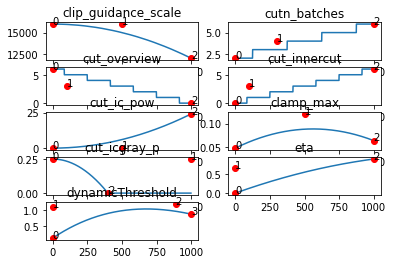

In [10]:
#@title Local Settings
try:
    from google.colab import files
except:
    #Modifying settings for local notebook easier here
    batch_name = 'DDT'
    n_batches = 5
    width_height_for_512x512_models = [960,576]
    steps = 500
    set_seed = 'random_seed'
    display_rate = 20
    intermediate_saves = [50, 100, 150, 200, 250, 300, 350, 400, 450]
    intermediates_in_subfolder = True
    clip_guidance_scale = [[0,16000],[500,16000],[1000,12000]]
    frames_skip_steps = "0%"
    tv_scale = 15000
    range_scale = 40000
    sat_scale = 40000
    cutn_batches = [[0,2],[300,4],[1000,6]]
    cut_overview = [[0,6],[100,3],[1000,0]]      
    cut_innercut = [[0,0],[100,3],[1000,6]]
    cut_ic_pow = [[0,0],[500,0.0],[1000,24]]
    cut_icgray_p = [[0,0.25],[1000,0.25],[400,0]]
    clamp_grad = True
    clamp_max = [[0,0.048],[500,0.12],[1000,0.064]]
    eta = [[0,0.0],[0,0.64],[1000,0.88]]
    perlin_init = True
    perlin_mode = 'mixed'
    skip_augs = False
    use_vertical_symmetry = False
    use_horizontal_symmetry = False
    transformation_percent = [0.09]
    dynamicThreshold=[[0,0.12],[0,1.1],[888,1.2],[1000,0.88]]

    #Settings cleanup
    width_height = width_height_for_256x256_models if diffusion_model in diffusion_models_256x256_list else width_height_for_512x512_models
    side_x = (width_height[0]//64)*64;
    side_y = (width_height[1]//64)*64;
    if side_x != width_height[0] or side_y != width_height[1]:
        print(f'Changing output size to {side_x}x{side_y}. Dimensions must by multiples of 64.')
    batchFolder = f'{outDirPath}/{batch_name}'
    createPath(batchFolder)
    if type(intermediate_saves) is not list:
        if intermediate_saves:
            steps_per_checkpoint = math.floor((steps - skip_steps - 1) // (intermediate_saves+1))
            steps_per_checkpoint = steps_per_checkpoint if steps_per_checkpoint > 0 else 1
            print(f'Will save every {steps_per_checkpoint} steps')
        else:
            steps_per_checkpoint = steps+10
    else:
        steps_per_checkpoint = None
    if intermediate_saves and intermediates_in_subfolder is True:
        partialFolder = f'{batchFolder}/partials'
        createPath(partialFolder)
finally:
    pass
    plt.rcParams["figure.figsize"]=16,16      
    plt.subplot(5, 2, 1)
    plot_bezier(clip_guidance_scale, True)
    plt.subplot(5, 2, 2)
    plot_bezier(cutn_batches, True)
    plt.subplot(5, 2, 3)
    plot_bezier(cut_overview, True)
    plt.subplot(5, 2, 4)
    plot_bezier(cut_innercut, True)
    plt.subplot(5, 2, 5)
    plot_bezier(cut_ic_pow)
    plt.subplot(5, 2, 6)
    plot_bezier(clamp_max)
    plt.subplot(5, 2, 7)
    plot_bezier(cut_icgray_p)
    plt.subplot(5, 2, 8)
    plot_bezier(eta)
    plt.subplot(5, 2, 9)
    plot_bezier(dynamicThreshold)

### Prompts

In [11]:
# Note: If using a pixelart diffusion model, try adding "#pixelart" to the end of the prompt for a stronger effect. It'll tend to work a lot better!
text_prompts = {
    0: ["Ancient Pyramid of the Dragon Gods, by federico pelat and greg rutkowski, a beautifully ultradetailed painting of an ancient Egyptian pyramid that glows with a gentle noble aura with statues and monuments to dragon gods, trending on artstation, 4k, ultrawide lens:3",
            "people, dof, blur:-1",
       ],
}

image_prompts = {
    # 0:['ImagePromptsWorkButArentVeryGood.png:2',],
}

# 4. Diffuse!

In [ ]:
#@title Do the Run!
#@markdown `n_batches` ignored with animation modes.

#Update Model Settings
timestep_respacing = f'ddim{steps}'
diffusion_steps = (1000//steps)*steps if steps < 1000 else steps
model_config.update({
    'timestep_respacing': timestep_respacing,
    'diffusion_steps': diffusion_steps,
})

batch_size = 1 

def move_files(start_num, end_num, old_folder, new_folder):
    for i in range(start_num, end_num):
        old_file = old_folder + f'/{batch_name}({batchNum})_{i:04}.png'
        new_file = new_folder + f'/{batch_name}({batchNum})_{i:04}.png'
        os.rename(old_file, new_file)

#@markdown ---


resume_run = False #@param{type: 'boolean'}
run_to_resume = 'latest' #@param{type: 'string'}
resume_from_frame = 'latest' #@param{type: 'string'}
retain_overwritten_frames = False #@param{type: 'boolean'}
if retain_overwritten_frames:
    retainFolder = f'{batchFolder}/retained'
    createPath(retainFolder)


skip_step_ratio = int(frames_skip_steps.rstrip("%")) / 100
calc_frames_skip_steps = math.floor(steps * skip_step_ratio)

if steps <= calc_frames_skip_steps:
    sys.exit("ERROR: You can't skip more steps than your total steps")

start_frame = 0
batchNum = len(glob(batchFolder+"/*.txt"))
while os.path.isfile(f"{batchFolder}/{batch_name}({batchNum})_settings.txt") or os.path.isfile(f"{batchFolder}/{batch_name}-{batchNum}_settings.txt"):
    batchNum += 1

print(f'Starting Run: {batch_name}({batchNum}) at frame {start_frame}')

if set_seed == 'random_seed':
    random.seed()
    seed = random.randint(0, 2**32)
    # print(f'Using seed: {seed}')
else:
    seed = int(set_seed)

    
args = {
    'batchNum': batchNum,
    'prompts_series': text_prompts[0] if text_prompts else None,
    'image_prompts_series':image_prompts[0] if image_prompts else None,
    'seed': seed,
    'display_rate':display_rate,
    'n_batches':n_batches,
    'batch_size':batch_size,
    'batch_name': batch_name,
    'steps': steps,
    'diffusion_sampling_mode': diffusion_sampling_mode,
    'width_height': width_height,
    'clip_guidance_scale': bezier_curve(clip_guidance_scale, True)[1],
    'tv_scale': tv_scale,
    'range_scale': range_scale,
    'sat_scale': sat_scale,
    'cutn_batches': bezier_curve(cutn_batches, True)[1],
    'init_image': init_image,
    'init_scale': init_scale,
    'skip_steps': skip_steps,
    'side_x': side_x,
    'side_y': side_y,
    'timestep_respacing': timestep_respacing,
    'diffusion_steps': diffusion_steps,
    'sampling_mode': sampling_mode,
    'skip_step_ratio': skip_step_ratio,
    'calc_frames_skip_steps': calc_frames_skip_steps,
    'text_prompts': text_prompts,
    'image_prompts': image_prompts,
    'cut_overview': bezier_curve(cut_overview, True)[1],
    'cut_innercut': bezier_curve(cut_innercut, True)[1],
    'cut_ic_pow': bezier_curve(cut_ic_pow)[1],
    'cut_icgray_p': bezier_curve(cut_icgray_p)[1],
    'intermediate_saves': intermediate_saves,
    'intermediates_in_subfolder': intermediates_in_subfolder,
    'steps_per_checkpoint': steps_per_checkpoint,
    'perlin_init': perlin_init,
    'perlin_mode': perlin_mode,
    'set_seed': set_seed,
    'eta': bezier_curve(eta)[1],
    "dynamicThreshold": bezier_curve(dynamicThreshold)[1],
    'clamp_grad': clamp_grad,
    'clamp_max': bezier_curve(clamp_max)[1],
    'skip_augs': skip_augs,
    'randomize_class': randomize_class,
    'clip_denoised': clip_denoised,
    'fuzzy_prompt': fuzzy_prompt,
    'rand_mag': rand_mag,
    'use_vertical_symmetry': use_vertical_symmetry,
    'use_horizontal_symmetry': use_horizontal_symmetry,
    'transformation_percent': transformation_percent,
    'animation_mode': 'None',
}


args = SimpleNamespace(**args)

print('Prepping model...')
model, diffusion = create_model_and_diffusion(**model_config)
if diffusion_model == 'custom':
    model.load_state_dict(torch.load(custom_path, map_location='cpu'))
else:
    model.load_state_dict(torch.load(f'{model_path}/{get_model_filename(diffusion_model)}', map_location='cpu'))
model.requires_grad_(False).eval().to(device)
for name, param in model.named_parameters():
    if 'qkv' in name or 'norm' in name or 'proj' in name:
        param.requires_grad_()
if model_config['use_fp16']:
    model.convert_to_fp16()

gc.collect()
torch.cuda.empty_cache()
try:
    do_run()
except KeyboardInterrupt:
    pass
finally:
    print('Seed used:', seed)
    gc.collect()
    torch.cuda.empty_cache()

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Output()

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
class BezierCurve:
    def __init__(self, list_of_points):
        self.list_of_points = list_of_points
        self.degree = len(list_of_points) - 1

    def basis_function(self, t) :

        output_values = []
        for i in range(len(self.list_of_points)):
            output_values.append(
                comb(self.degree, i) * ((1 - t) ** (self.degree - i)) * (t**i)
            )
        return output_values

    def bezier_curve_function(self, t):

        basis_function = self.basis_function(t)
        x = 0.0
        y = 0.0
        for i in range(len(self.list_of_points)):
            # For all points, sum up the product of i-th basis function and i-th point.
            x += basis_function[i] * self.list_of_points[i][0]
            y += basis_function[i] * self.list_of_points[i][1]
        return (x, y)

    def plot_curve(self, step_size=0.01):
        from matplotlib import pyplot as plt  # type: ignore

        to_plot_x = []  # x coordinates of points to plot
        to_plot_y = []  # y coordinates of points to plot

        t = 0.0
        while t <= 1:
            value = self.bezier_curve_function(t)
            to_plot_x.append(value[0])
            to_plot_y.append(value[1])
            t += step_size

        x = [i[0] for i in self.list_of_points]
        y = [i[1] for i in self.list_of_points]

        plt.plot(
            to_plot_x,
            to_plot_y,
            color="blue",
            label="Curve of Degree " + str(self.degree),
        )
        plt.scatter(x, y, color="red", label="Control Points")
        plt.legend()
        plt.show()
    def outcurve(self):
        from matplotlib import pyplot as plt  # type: ignore

        to_plot_x = []  # x coordinates of points to plot
        to_plot_y = []  # y coordinates of points to plot

        t = 0.0
        while t <= 1:
            value = self.bezier_curve_function(t)
            to_plot_x.append(value[0])
            to_plot_y.append(value[1])
            t += 0.001

        x = [i[0] for i in self.list_of_points]
        y = [i[1] for i in self.list_of_points]
        print(len(to_plot_y))
        print(to_plot_x)
        plt.plot(
            to_plot_x,
            to_plot_y,
            color="blue",
            label="Curve of Degree " + str(self.degree),
        )
        plt.scatter(x, y, color="red", label="Control Points")
        plt.legend()
        plt.show()




BezierCurve([(0, 2), (2, 2), (0, 0), (2, 0)]).plot_curve()  # degree 3
BezierCurve([(0, 2), (200, 2), (0, 0), (1000, 0)]).outcurve()